In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [2]:
station = "Hot"

In [3]:
data = xr.load_dataset(f"./products/{station}_obs_filtered.zarr", engine="zarr")
data

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 514, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 4kB 1994-02-17 1994-02-18 ... 2022-09-01
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB 1.052 ... 5.704
    night      (time, latitude, longitude, layer) float64 4kB 3.699 ... 6.061
Attributes:
    creation date:  2024-10-13T20:03:40.309826
    layer:          epipelagic
    station:        Hot

## Number of samples


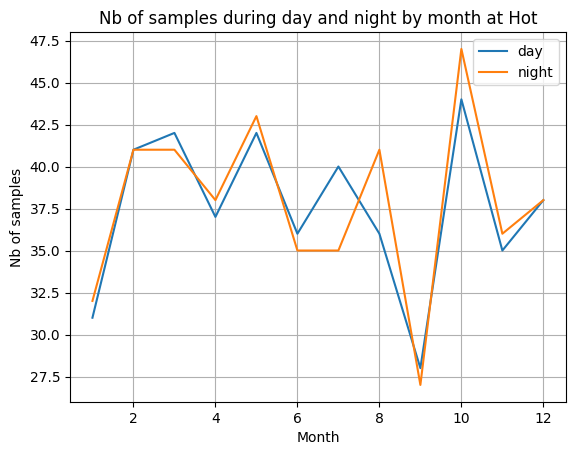

In [4]:
data.groupby("time.month").count().day[:, 0, 0, 0].plot(label="day")
data.groupby("time.month").count().night[:, 0, 0, 0].plot(label="night")
plt.legend()
plt.title(f"Nb of samples during day and night by month at {station}")
plt.xlabel("Month")
plt.ylabel("Nb of samples")
plt.grid()
plt.show()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


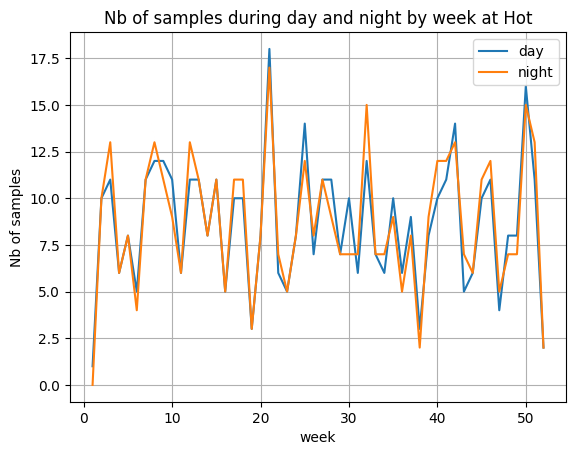

In [5]:
data.groupby("time.week").count().day[:, 0, 0, 0].plot(label="day")
data.groupby("time.week").count().night[:, 0, 0, 0].plot(label="night")
plt.legend()
plt.title(f"Nb of samples during day and night by week at {station}")
plt.xlabel("week")
plt.ylabel("Nb of samples")
plt.grid()
plt.show()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


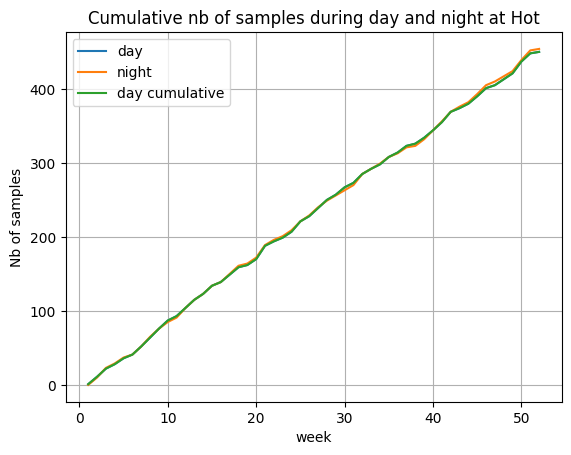

In [6]:
data.groupby("time.week").count().day[:, 0, 0, 0].cumsum().plot(label="day")
data.groupby("time.week").count().night[:, 0, 0, 0].cumsum().plot(label="night")
# cumulative plot
data.groupby("time.week").count().day[:, 0, 0, 0].cumsum().plot(label="day cumulative")
plt.legend()
plt.title(f"Cumulative nb of samples during day and night at {station}")
plt.xlabel("week")
plt.ylabel("Nb of samples")
plt.grid()
plt.show()

## Computing the trend


/var/folders/36/grrgsqjd14j4tf6cf5ty4ykh0000gn/T/ipykernel_54003/3280676768.py:6: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_indices = (day_data["time"] - day_data["time"][0]).astype("timedelta64[D]").astype(int)
/var/folders/36/grrgsqjd14j4tf6cf5ty4ykh0000gn/T/ipykernel_54003/3280676768.py:13: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanos

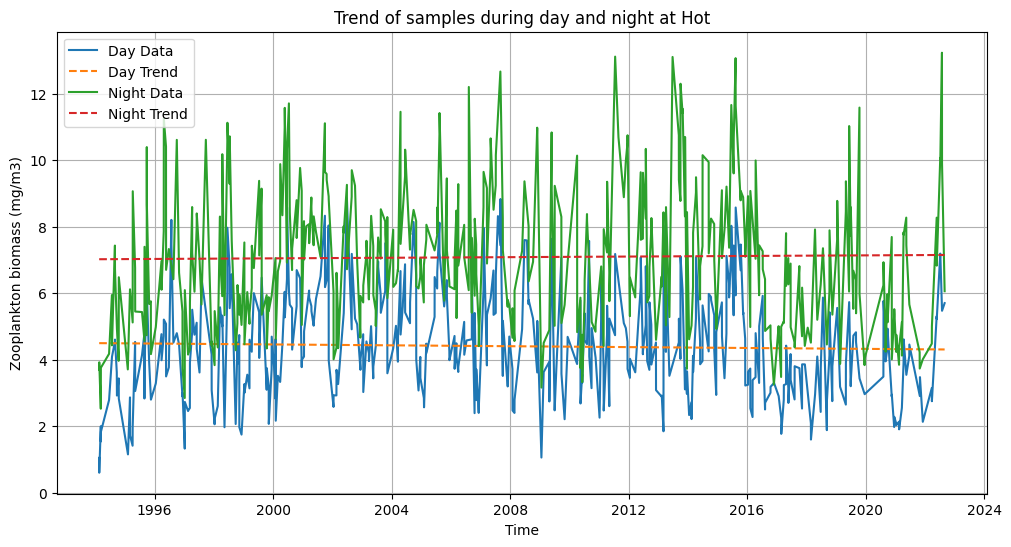

In [7]:
# Extraire les données de jour et de nuit
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

# Extraire les indices de temps en jours
time_indices = (day_data["time"] - day_data["time"][0]).astype("timedelta64[D]").astype(int)

# Ajuster une ligne droite aux données de jour
day_trend = np.polyfit(time_indices, day_data, 1)
day_trend_line = np.polyval(day_trend, time_indices)

# Ajuster une ligne droite aux données de nuit
night_time_indices = (night_data["time"] - night_data["time"][0]).astype("timedelta64[D]").astype(int)
night_trend = np.polyfit(night_time_indices, night_data, 1)
night_trend_line = np.polyval(night_trend, night_time_indices)

# Tracer les données et les tendances
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_trend_line, label="Day Trend", linestyle="--")
plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_trend_line, label="Night Trend", linestyle="--")
plt.legend()
plt.title(f"Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

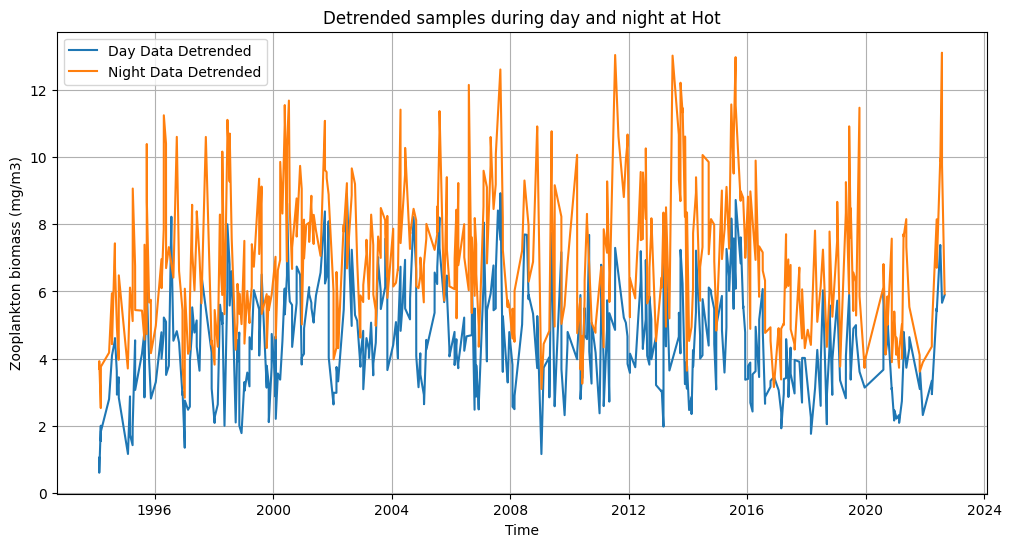

In [8]:
# Soustraire la tendance des données de jour
day_detrended = (day_data - day_trend_line) + day_trend_line[0]

# Soustraire la tendance des données de nuit
night_detrended = (night_data - night_trend_line) + night_trend_line[0]

# Tracer les données détrendées
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_detrended, label="Day Data Detrended")
plt.plot(night_data["time"], night_detrended, label="Night Data Detrended")
plt.legend()
plt.title(f"Detrended samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Group data by week


In [9]:
grouped_data = xr.Dataset({"day": day_detrended, "night": night_detrended})

# Calculer les moyennes mensuelles des données détrendées
grouped_data = grouped_data.groupby("time.week").mean()
grouped_data

# ajouter des nan pour les semaines manquantes
grouped_data = grouped_data.reindex(week=np.arange(1, 53))
grouped_data

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


<xarray.Dataset> Size: 1kB
Dimensions:    (week: 52)
Coordinates:
    latitude   float64 8B 22.75
    layer      int64 8B 0
    longitude  int64 8B -158
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week) float64 416B 2.373 2.644 3.801 4.005 ... 3.823 3.564 3.842
    night      (week) float64 416B nan 5.617 6.089 5.595 ... 5.946 5.928 6.966

## Raw data, no smoothing


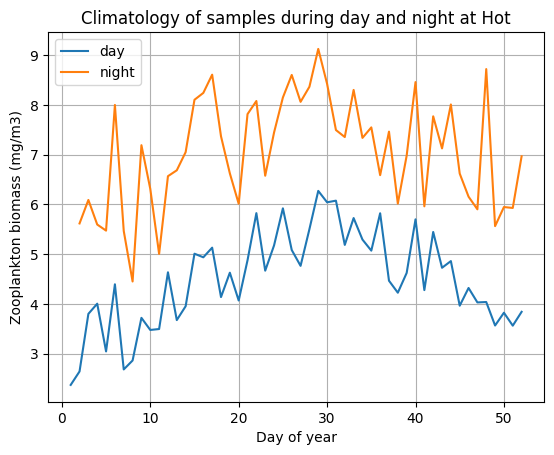

In [10]:
grouped_data.day.dropna("week").plot(label="day")
grouped_data.night.dropna("week").plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Smooth


In [11]:
window_size = 3
pad_size = window_size + 2

# Étendre les données pour simuler la cyclicité
extended_ds = grouped_data.pad(week=(pad_size, pad_size), mode="wrap")

# Appliquer la fenêtre mobile
smoothed = (
    extended_ds.rolling(week=window_size, center=True, min_periods=1)
    .mean()
    .isel(week=slice(pad_size, -pad_size))  # Revenir à la taille originale
)
smoothed

<xarray.Dataset> Size: 1kB
Dimensions:    (week: 52)
Coordinates:
    latitude   float64 8B 22.75
    layer      int64 8B 0
    longitude  int64 8B -158
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week) float64 416B 2.953 2.939 3.483 3.618 ... 3.651 3.743 3.26
    night      (week) float64 416B 6.291 5.853 5.767 5.719 ... 5.812 6.28 6.447

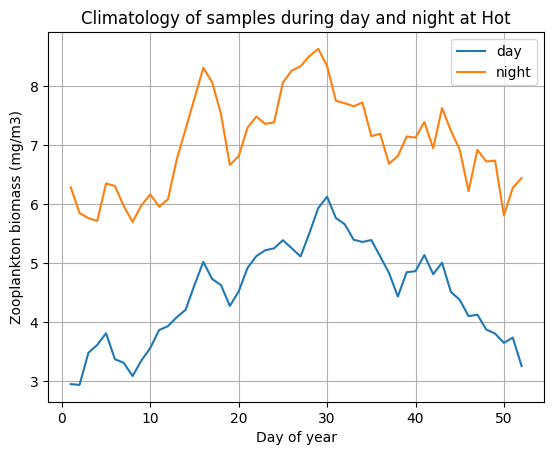

In [12]:
smoothed.day.plot(label="day")
smoothed.night.plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Duplicating observation across the entire time period


In [13]:
value_by_week = smoothed.to_dataframe().drop(columns=["latitude", "longitude", "layer"])
value_by_week.head()

,day,night
week,,
1,2.953109,6.291240
2,2.939476,5.852779
3,3.483409,5.766851
4,3.617510,5.718761
5,3.815409,6.354814


In [14]:
week_by_day = (
    pd.date_range(start=data.indexes["time"][0], end=data.indexes["time"][-1], freq="W")
    .isocalendar()
    .drop(columns=["day", "year"])
)
week_by_day.head()

,week
1994-02-20,7
1994-02-27,8
1994-03-06,9
1994-03-13,10
1994-03-20,11


In [15]:
aggregated_smoothed_detrended = week_by_day.join(value_by_week, on="week").drop(columns=["week"])
aggregated_smoothed_detrended

,day,night
1994-02-20,3.314366,5.971164
1994-02-27,3.089774,5.701716
1994-03-06,3.354089,5.983836
1994-03-13,3.564766,6.168745
1994-03-20,3.869646,5.961310
...,...,...
2022-07-31,6.128750,8.345156
2022-08-07,5.767152,7.755195
2022-08-14,5.661658,7.714725
2022-08-21,5.401270,7.662174


In [16]:
# Créer une série temporelle pour les tendances de jour et de nuit
day_trend_series = pd.Series(day_trend_line - day_trend_line[0], index=day_data["time"].values)
night_trend_series = pd.Series(night_trend_line - night_trend_line[0], index=night_data["time"].values)

# Réindexer les séries temporelles pour correspondre à l'index de aggregated_smoothed_detrended
day_trend_interpolated = day_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")
night_trend_interpolated = night_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")

# Ajouter les tendances interpolées au DataFrame aggregated_smoothed_detrended
aggregated_smoothed_detrended["day_trend"] = day_trend_interpolated
aggregated_smoothed_detrended["night_trend"] = night_trend_interpolated

aggregated_smoothed_detrended.index.name = "time"

# Afficher le DataFrame avec les tendances ajoutées
aggregated_smoothed_detrended.head()

,day,night,day_trend,night_trend
time,,,,
1994-02-20,3.314366,5.971164,-0.000018,0.000012
1994-02-27,3.089774,5.701716,-0.000018,0.000012
1994-03-06,3.354089,5.983836,-0.000365,0.000246
1994-03-13,3.564766,6.168745,-0.000401,0.000258
1994-03-20,3.869646,5.961310,-0.000401,0.000258


In [17]:
climato_observations = xr.Dataset.from_dataframe(aggregated_smoothed_detrended)
climato_observations

<xarray.Dataset> Size: 60kB
Dimensions:      (time: 1489)
Coordinates:
  * time         (time) datetime64[ns] 12kB 1994-02-20 1994-02-27 ... 2022-08-28
Data variables:
    day          (time) float64 12kB 3.314 3.09 3.354 ... 5.662 5.401 5.363
    night        (time) float64 12kB 5.971 5.702 5.984 ... 7.715 7.662 7.727
    day_trend    (time) float64 12kB -1.823e-05 -1.823e-05 ... -0.19 -0.19
    night_trend  (time) float64 12kB 1.229e-05 1.229e-05 ... 0.1281 0.1281

## Plot final results


In [18]:
fig = make_subplots(rows=1, cols=1)

# Ajouter les données de jour et de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["day"] + aggregated_smoothed_detrended["day_trend"],
        mode="lines",
        name="Day Data with Trend",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["night"] + aggregated_smoothed_detrended["night_trend"],
        mode="lines",
        name="Night Data with Trend",
    ),
    row=1,
    col=1,
)

# Ajouter les tendances de jour et de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["day_trend"],
        mode="lines",
        name="Day Trend",
        line=dict(dash="dash"),
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["night_trend"],
        mode="lines",
        name="Night Trend",
        line=dict(dash="dash"),
    ),
    row=1,
    col=1,
)

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Evolution des données de jour et de nuit avec tendance à {station}",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

In [19]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données obtenues après traitement de jour
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["day"] + aggregated_smoothed_detrended["day_trend"],
        mode="lines",
        name="Processed Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# Ajouter les données obtenues après traitement de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["night"] + aggregated_smoothed_detrended["night_trend"],
        mode="lines",
        name="Processed Night Data",
    ),
    row=2,
    col=1,
)

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : With Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

In [20]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données obtenues après traitement de jour
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["day"],
        mode="lines",
        name="Processed Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# Ajouter les données obtenues après traitement de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed_detrended.index,
        y=aggregated_smoothed_detrended["night"],
        mode="lines",
        name="Processed Night Data",
    ),
    row=2,
    col=1,
)

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : Without Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

## Export


In [21]:
climato_observations = climato_observations.expand_dims(
    latitude=[data.latitude[0]], longitude=[data.longitude[0]], layer=[data.layer[0]]
)
climato_observations = climato_observations.transpose("time", "latitude", "longitude", "layer")

In [22]:
climato_observations.latitude.attrs = data.latitude.attrs
climato_observations.longitude.attrs = data.longitude.attrs
climato_observations.layer.attrs = data.layer.attrs
climato_observations.time.attrs = data.time.attrs
climato_observations.day.attrs = data.day.attrs
climato_observations.night.attrs = data.night.attrs
climato_observations.day_trend.attrs = {"units": "mg/m3", "long_name": "Day Trend"}
climato_observations.night_trend.attrs = {"units": "mg/m3", "long_name": "Night Trend"}
climato_observations

<xarray.Dataset> Size: 60kB
Dimensions:      (latitude: 1, longitude: 1, layer: 1, time: 1489)
Coordinates:
  * latitude     (latitude) float64 8B 22.75
  * longitude    (longitude) int64 8B -158
  * layer        (layer) int64 8B 0
  * time         (time) datetime64[ns] 12kB 1994-02-20 1994-02-27 ... 2022-08-28
Data variables:
    day          (time, latitude, longitude, layer) float64 12kB 3.314 ... 5.363
    night        (time, latitude, longitude, layer) float64 12kB 5.971 ... 7.727
    day_trend    (time, latitude, longitude, layer) float64 12kB -1.823e-05 ....
    night_trend  (time, latitude, longitude, layer) float64 12kB 1.229e-05 .....

In [23]:
climato_observations.to_zarr(f"./products/{station}_climato.zarr", mode="w")